In [1]:
import os
import glob

In [2]:
base_dir = os.path.join('D:\Data science\cell_images')

In [3]:
infected_dir = os.path.join(base_dir,'Parasitized')

In [4]:
healthy_dir = os.path.join(base_dir,'Uninfected')

In [5]:
infected_files = glob.glob(infected_dir+'/*.png')
healthy_files = glob.glob(healthy_dir+'/*.png')

In [6]:
len(infected_files), len(healthy_files)

(13779, 13779)

In [7]:
import numpy as np
import pandas as pd

In [8]:
np.random.seed(42)

In [9]:
files_df = pd.DataFrame({
    'filename': infected_files + healthy_files,
    'label': ['malaria'] * len(infected_files) + ['healthy'] * len(healthy_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

In [10]:
files_df.head()

,filename,label
0,D:\Data science\cell_images\Parasitized\C130P9...,malaria
1,D:\Data science\cell_images\Parasitized\C188P1...,malaria
2,D:\Data science\cell_images\Uninfected\C173P13...,healthy
3,D:\Data science\cell_images\Uninfected\C78P39T...,healthy
4,D:\Data science\cell_images\Uninfected\C107P68...,healthy


In [11]:
from sklearn.model_selection import train_test_split

In [12]:
from collections import Counter

In [13]:
train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.1, random_state=42)

In [14]:
print(train_files.shape, val_files.shape, test_files.shape)

(17361,) (1929,) (8268,)


In [15]:
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

Train: Counter({'healthy': 8734, 'malaria': 8627}) 
Val: Counter({'healthy': 970, 'malaria': 959}) 
Test: Counter({'malaria': 4193, 'healthy': 4075})


In [16]:
import cv2

In [17]:
from concurrent import futures

In [18]:
import threading

In [19]:
def get_img_shape_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    return cv2.imread(img).shape

In [20]:
ex = futures.ThreadPoolExecutor(max_workers=None)

In [21]:
data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]

In [22]:
print('Starting Img shape computation:')

Starting Img shape computation:


In [23]:
train_img_dims_map = ex.map(get_img_shape_parallel, 
                            [record[0] for record in data_inp],
                            [record[1] for record in data_inp],
                            [record[2] for record in data_inp])

ThreadPoolExecutor-0_0: working on img num: 0


In [24]:
train_img_dims = list(train_img_dims_map)
print('Min Dimensions:', np.min(train_img_dims, axis=0)) 
print('Avg Dimensions:', np.mean(train_img_dims, axis=0))
print('Median Dimensions:', np.median(train_img_dims, axis=0))
print('Max Dimensions:', np.max(train_img_dims, axis=0))

ThreadPoolExecutor-0_4: working on img num: 5000
ThreadPoolExecutor-0_38: working on img num: 10000
ThreadPoolExecutor-0_5: working on img num: 15000
ThreadPoolExecutor-0_35: working on img num: 17360
Min Dimensions: [46 49  3]
Avg Dimensions: [132.89856575 132.50751685   3.        ]
Median Dimensions: [130. 130.   3.]
Max Dimensions: [382 394   3]


In [25]:
IMG_DIMS = (125, 125)

In [26]:
def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

In [27]:
ex = futures.ThreadPoolExecutor(max_workers=None)

In [28]:
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

In [29]:
print('Loading Train Images:')

Loading Train Images:


In [30]:
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])

ThreadPoolExecutor-1_0: working on img num: 0


In [31]:
train_data = np.array(list(train_data_map))

ThreadPoolExecutor-1_35: working on img num: 5000
ThreadPoolExecutor-1_30: working on img num: 10000
ThreadPoolExecutor-1_20: working on img num: 15000
ThreadPoolExecutor-1_35: working on img num: 17360


In [32]:
print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))


Loading Validation Images:
ThreadPoolExecutor-1_15: working on img num: 0
ThreadPoolExecutor-1_39: working on img num: 1928


In [33]:
print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))


Loading Test Images:
ThreadPoolExecutor-1_35: working on img num: 0
ThreadPoolExecutor-1_2: working on img num: 5000
ThreadPoolExecutor-1_3: working on img num: 8267


In [34]:
train_data.shape, val_data.shape, test_data.shape 

((17361, 125, 125, 3), (1929, 125, 125, 3), (8268, 125, 125, 3))

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

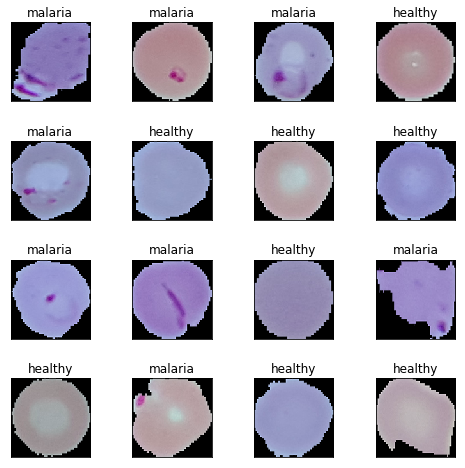

In [36]:
plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [37]:
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 25
INPUT_SHAPE = (125, 125, 3)

In [38]:
train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.

In [39]:
from sklearn.preprocessing import LabelEncoder

In [40]:
le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

print(train_labels[:6], train_labels_enc[:6])

['malaria' 'malaria' 'malaria' 'healthy' 'healthy' 'malaria'] [1 1 1 0 0 1]


In [41]:
import tensorflow as tf

In [42]:
%load_ext tensorboard

In [43]:
tf.random.set_seed(42)
tf.__version__

'2.0.0'

In [44]:
inp = tf.keras.layers.Input(shape=INPUT_SHAPE)

conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(inp)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool2)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

flat = tf.keras.layers.Flatten()(pool3)

hidden1 = tf.keras.layers.Dense(512, activation='relu')(flat)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 125, 125, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 128)       0     

In [45]:
import datetime

In [46]:




history = model.fit(x=train_imgs_scaled, y=train_labels_enc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_imgs_scaled, val_labels_enc), 
                    verbose=1)

Train on 17361 samples, validate on 1929 samples
Epoch 1/25
17361/17361 [==============================] - 411s 24ms/sample - loss: 0.4083 - accuracy: 0.7984 - val_loss: 0.1994 - val_accuracy: 0.9435
Epoch 2/25
17361/17361 [==============================] - 403s 23ms/sample - loss: 0.1717 - accuracy: 0.9468 - val_loss: 0.1406 - val_accuracy: 0.9487
Epoch 3/25
17361/17361 [==============================] - 401s 23ms/sample - loss: 0.1397 - accuracy: 0.9546 - val_loss: 0.1371 - val_accuracy: 0.9590
Epoch 4/25
17361/17361 [==============================] - 399s 23ms/sample - loss: 0.1274 - accuracy: 0.9578 - val_loss: 0.1301 - val_accuracy: 0.9590
Epoch 5/25
17361/17361 [==============================] - 399s 23ms/sample - loss: 0.1111 - accuracy: 0.9625 - val_loss: 0.1336 - val_accuracy: 0.9585
Epoch 6/25
17361/17361 [==============================] - 398s 23ms/sample - loss: 0.0975 - accuracy: 0.9671 - val_loss: 0.1482 - val_accuracy: 0.9492
Epoch 7/25
17361/17361 [=====================

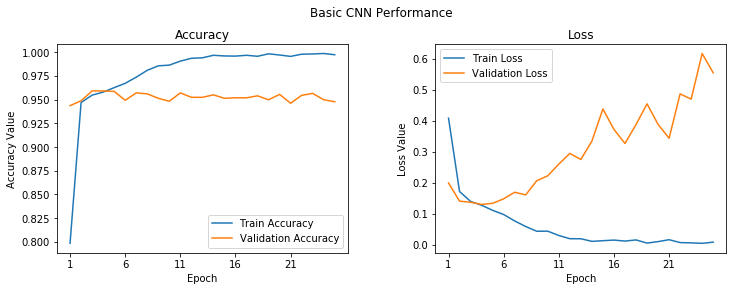

In [47]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [48]:
model.save('basic_cnn.h5')

In [49]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
vgg.trainable = False
# Freeze the layers
for layer in vgg.layers:
    layer.trainable = False
    
base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_vgg.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 125, 125, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 125, 125, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 62, 62, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 62, 62, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 62, 62, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 31, 31, 128)       0   

In [50]:
print("Total Layers:", len(model.layers))
print("Total trainable layers:", 
      sum([1 for l in model.layers if l.trainable]))

Total Layers: 28
Total trainable layers: 6


In [51]:
model.save('vgg_frozen.h5')

In [52]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                zoom_range=0.05, 
                                                                rotation_range=25,
                                                                width_shift_range=0.05, 
                                                                height_shift_range=0.05, 
                                                                shear_range=0.05, horizontal_flip=True, 
                                                                fill_mode='nearest')

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# build image augmentation generators
train_generator = train_datagen.flow(train_data, train_labels_enc, batch_size=BATCH_SIZE, shuffle=True)
val_generator = val_datagen.flow(val_data, val_labels_enc, batch_size=BATCH_SIZE, shuffle=False)


Labels: ['malaria', 'malaria', 'malaria', 'malaria', 'malaria']


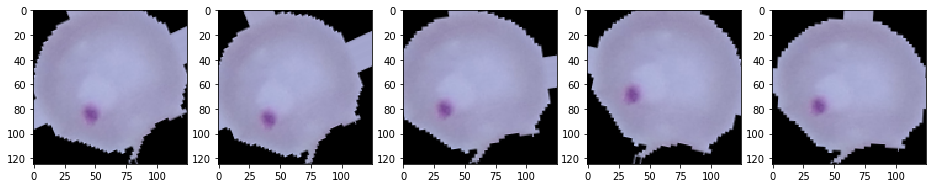

In [53]:
img_id = 0
sample_generator = train_datagen.flow(train_data[img_id:img_id+1], train_labels[img_id:img_id+1],
                                      batch_size=1)
sample = [next(sample_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in sample])
l = [ax[i].imshow(sample[i][0][0]) for i in range(0,5)]

In [54]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
# Freeze the layers
vgg.trainable = True

set_trainable = False
for layer in vgg.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    
base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_vgg.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
                loss='binary_crossentropy',
                metrics=['accuracy'])

print("Total Layers:", len(model.layers))
print("Total trainable layers:", sum([1 for l in model.layers if l.trainable]))

Total Layers: 28
Total trainable layers: 16


In [55]:
train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = val_generator.n // val_generator.batch_size
history = model.fit_generator(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=5,
                              validation_data=val_generator, validation_steps=val_steps_per_epoch, 
                              verbose=1)

Epoch 1/5
271/271 [==============================] - 8419s 31s/step - loss: 0.2326 - accuracy: 0.9040 - val_loss: 0.1322 - val_accuracy: 0.9568
Epoch 2/5
271/271 [==============================] - 8221s 30s/step - loss: 0.1416 - accuracy: 0.9529 - val_loss: 0.1214 - val_accuracy: 0.9615
Epoch 3/5
271/271 [==============================] - 7866s 29s/step - loss: 0.1295 - accuracy: 0.9566 - val_loss: 0.1405 - val_accuracy: 0.9552
Epoch 4/5
271/271 [==============================] - 7853s 29s/step - loss: 0.1201 - accuracy: 0.9599 - val_loss: 0.1017 - val_accuracy: 0.9641
Epoch 5/5
271/271 [==============================] - 7891s 29s/step - loss: 0.1163 - accuracy: 0.9605 - val_loss: 0.1370 - val_accuracy: 0.9568


In [63]:
import model_evaluation_utils as meu
import pandas as pd

basic_cnn_metrics = meu.get_metrics(true_labels=test_labels, predicted_labels=basic_cnn_pred_labels)
vgg_frz_metrics = meu.get_metrics(true_labels=test_labels, predicted_labels=vgg_frz_pred_labels)
vgg_ft_metrics = meu.get_metrics(true_labels=test_labels, predicted_labels=vgg_ft_pred_labels)

pd.DataFrame([basic_cnn_metrics, vgg_frz_metrics, vgg_ft_metrics], 
             index=['Basic CNN', 'VGG-19 Frozen', 'VGG-19 Fine-tuned'])


ModuleNotFoundError: No module named 'model_evaluation_utils'